# Homework 1 Rubenchik Mark

Мы собираемся работать со следующим набором данных: ток жидкости в трубке. Некоторая статистика собрана для набора данных, в т.ч. среднее значение, асимметрия, эксцесс и т.д. Мы прогнозируем скорость потока ("tohn/час"). Нам нужно создать доверительные и прогностические интервалы.

In [1]:
%matplotlib inline

import numpy as np
from sklearn import datasets, linear_model, preprocessing, model_selection
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats as st
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

from scipy.stats import beta

In [2]:
data = pd.read_csv('exxsol_data.csv', sep=';', header=(0))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean       700 non-null    float64
 1   std        700 non-null    float64
 2   skew       700 non-null    float64
 3   kurt       700 non-null    float64
 4   RMS        700 non-null    float64
 5   crest      700 non-null    float64
 6   freq_peak  700 non-null    float64
 7   shan       700 non-null    float64
 8   perm       700 non-null    float64
 9   temp       700 non-null    float64
 10  tohn/hour  700 non-null    float64
dtypes: float64(11)
memory usage: 60.3 KB


In [4]:
y = data['tohn/hour']
freq_temp = data[['freq_peak','temp']]

In [5]:
freq_temp, y = shuffle(freq_temp, y)

# split data into training and testing sets
#from sklearn.model_selection import train_test_split
#train_freq, test_freq, train_y, test_y = train_test_split(freq, y, train_size=0.7, random_state=2)

lr = linear_model.LinearRegression()
predicted = model_selection.cross_val_predict(lr, freq_temp, y.ravel(), cv=20)
score = model_selection.cross_val_score(lr, freq_temp, y,scoring='r2',cv=20)

## Q0: Построить точечную оценку среднего коэф r2 и его отклонения

In [6]:
X = score
n = len(X)
X_mean = np.mean(X)
S_X = np.var(X, ddof=1)

_tconfint_generic(X_mean, np.sqrt(S_X), n - 1, 0.05, 'two-sided')

(0.7173407873355995, 0.9438972580627414)

## Q1: Predicted — это массив с предсказаниями метки y. При условии, что $\sigma = 0.1$, вычислить 95% доверительный интервал и прогностический интервал для среднеквадратичной ошибки. 

In [7]:
error = np.sqrt((y - predicted)**2)  
X_mean = np.mean(error)
sigma = 0.1
n = len(error)

confidence_int = _zconfint_generic(X_mean, 0.1, 0.05, 'two-sided')
predictive_int = _zconfint_generic(X_mean, sigma*(1+1/n), 0.05, 'two-sided')

print("confidence_int = ", confidence_int, "\n" + "predictive_int = ", predictive_int)

confidence_int =  (0.1253391792290629, 0.5173319761370737) 
predictive_int =  (0.1250591843741286, 0.517611970992008)


## Q2:  Вычислите 95% достоверный и предсказанный интервалы для среднеквадратичной ошибки, предполагая, что ничего не известно о $\sigma$.

In [8]:
error = np.sqrt((y - predicted)**2) 
print(error)
X_mean = np.mean(error)
sigma = 0.1
n = len(error)
S_X = np.var(error, ddof=1)

confidence_int = _tconfint_generic(X_mean, np.sqrt(S_X), n-1, 0.05, 'two-sided')
predictive_int = _tconfint_generic(X_mean, np.sqrt(S_X)*(1+1/n), n-1, 0.05,'two-sided')

print("confidence_int = ", confidence_int,  "\n" + "predictive_int = ", predictive_int)

669    0.271039
177    0.209853
22     0.367474
25     0.338178
432    0.142112
         ...   
149    0.197715
332    0.407761
383    0.432418
124    0.220976
505    0.394304
Name: tohn/hour, Length: 700, dtype: float64
confidence_int =  (-0.15870766391743152, 0.8013788192835681) 
predictive_int =  (-0.15939343997686078, 0.8020645953429975)


Мы можем использовать дополнительные функции и более сложную модель, например ElasticNet.

In [9]:
y = data['tohn/hour']
X = data.drop(['tohn/hour'],axis=1)
X = preprocessing.scale(X)
X, y = shuffle(X, y)

encv = linear_model.ElasticNetCV(cv=10,max_iter=3000, n_alphas=10)
predicted_encv = model_selection.cross_val_predict(encv, X, y.ravel(), cv=20)
score_encv = model_selection.cross_val_score(encv,X, y.ravel(),scoring='r2',cv=20)

## Q3:  Вычислите 95% доверительный интервал для отклонения средних значений среднеквадратичной ошибки между двумя моделями, предполагая, что ничего не известно о $\sigma$.

In [10]:
error = np.sqrt((y - predicted)**2) 
error_encv = np.sqrt((y - predicted_encv)**2) 


n,m = len(error), len(error_encv)
X_mean, Y_mean = np.mean(error), np.mean(error_encv)
S_X, S_Y = np.var(error, ddof=1), np.var(error_encv, ddof=1)
S_P = ((n-1) * S_X + (m-1) * S_Y) / (n + m - 2)


_tconfint_generic(X_mean - Y_mean,np.sqrt(S_P), n + m - 2, 0.05, 'two-sided')

(-0.21272472800452447, 2.0040630940582815)

## Q4: Реализовать UCB1

In [11]:
class Model:
    def __init__(self, probability, init_mean=0):
        self.probability = probability
        self.mean = init_mean
        if init_mean > 0:
             self.sample_size = 1
        else:
             self.sample_size = 0
    
    def execute(self):
        return np.random.uniform(0,1) < self.probability

    def update(self, x):
        self.sample_size += 1
        self.mean = ((self.sample_size - 1)*self.mean + x) / self.sample_size

In [12]:
def experiment(model_probs, eps, total=1000):
    models = [Model(p, init_mean=0) for p in model_probs]
    rewards = np.zeros(total)

    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0

    optimal_j = np.argmax([m.probability for m in models])
    print("optimal j:", optimal_j)
    
    for i in range(total):
        if np.random.uniform(0,1) < eps:
            num_times_explored += 1
            j = np.random.randint(len(models))
        else:
            num_times_exploited += 1
            j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])
        if j == optimal_j:
            num_optimal += 1
            
        # execute best model
        x = models[j].execute()

        # update rewards 
        rewards[i] = x

        # update the distribution for the executed model
        models[j].update(x)
        
    for m in models:
        print("mean estimate:", m.mean)
        
    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / total)
    print("num_times_explored:", num_times_explored)
    print("num_times_exploited:", num_times_exploited)
    print("num times selected optimal bandit:", num_optimal)

    # plot the results
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(total) + 1)
    plt.plot(win_rates)
    plt.plot(np.ones(total)*np.max(model_probs))
    plt.show()

optimal j: 2
mean estimate: 0.21428571428571427
mean estimate: 0.4451612903225807
mean estimate: 0.7501276943508015
total reward earned: 7424.0


C:\Users\markr\AppData\Local\Temp\ipykernel_31160\3334688345.py:18: RuntimeWarning: divide by zero encountered in log
  j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])
C:\Users\markr\AppData\Local\Temp\ipykernel_31160\3334688345.py:18: RuntimeWarning: invalid value encountered in sqrt
  j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])
C:\Users\markr\AppData\Local\Temp\ipykernel_31160\3334688345.py:18: RuntimeWarning: invalid value encountered in double_scalars
  j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])
C:\Users\markr\AppData\Local\Temp\ipykernel_31160\3334688345.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  j = np.argmax([m.mean + np.sqrt(2*np.log(i)/m.sample_size) for m in models])


overall win rate: 0.7424
num_times_explored: 0
num_times_exploited: 10000
num times selected optimal bandit: 9789


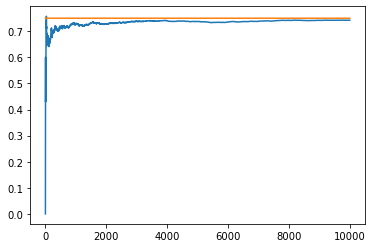

In [13]:
total = 10000
eps = 0
model_probs = [0.2, 0.5, 0.75]
experiment(model_probs, eps, total)